Heart Disease Prediction - Comprehensive Analysis  
Date: 2026-01-04  

This notebook performs end-to-end machine learning pipeline for predicting heart disease based on medical indicators.

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

import xgboost as xgb
import joblib

# 1. Settings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.2
Scikit-learn version: 1.6.1


# 2. Load Dataset
Load the Heart Disease dataset from Kaggle  
Dataset: https://www.kaggle.com/datasets/rishidamarla/heart-disease-prediction

In [3]:
df = pd.read_csv('data/heart_disease.csv')
print("✅ Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
df.head(3)

✅ Dataset loaded successfully!

Dataset shape: (270, 14)
Number of samples: 270
Number of features: 14


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence


# 2.5. Rename Columns to Standard Names

In [4]:
# Rename columns to standard short names for easier coding

# Mapping from current names to standard names
column_mapping = {
    'Age': 'age',
    'Sex': 'sex',
    'Chest pain type': 'cp',
    'BP': 'trestbps',
    'Cholesterol': 'chol',
    'FBS over 120': 'fbs',
    'EKG results': 'restecg',
    'Max HR': 'thalach',
    'Exercise angina': 'exang',
    'ST depression': 'oldpeak',
    'Slope of ST': 'slope',
    'Number of vessels fluro': 'ca',
    'Thallium':  'thal',
    'Heart Disease': 'target'
}

# Rename columns
df = df.rename(columns=column_mapping)

# Convert target to binary (0 = Absence, 1 = Presence)
df['target'] = (df['target'] == 'Presence').astype(int)

print("✅ Columns renamed successfully!")
print(f"\nNew column names: {list(df.columns)}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"\n0 = No Disease, 1 = Disease")

# Show first few rows with new names
display(df.head())

✅ Columns renamed successfully!

New column names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Target distribution:
target
0    150
1    120
Name: count, dtype: int64

0 = No Disease, 1 = Disease


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


# 3. Initial Data Exploration

In [5]:
# Quick overview of the dataset structure

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

# First rows
print("\n📊 First 5 rows:")
display(df.head())

print("\n📊 Last 5 rows:")
display(df.tail())

# Data types and non-null counts
print("\n📋 Dataset Info:")
df.info()


DATASET OVERVIEW

📊 First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0



📊 Last 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0
269,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   chol      270 non-null    int64  
 5   fbs       270 non-null    int64  
 6   restecg   270 non-null    int64  
 7   thalach   270 non-null    int64  
 8   exang     270 non-null    int64  
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    int64  
 11  ca        270 non-null    int64  
 12  thal      270 non-null    int64  
 13  target    270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB


# 4. Feature Description

In [6]:
# Understanding each feature in the dataset

feature_descriptions = {
    'age': 'Age in years',
    'sex': 'Sex (1 = male; 0 = female)',
    'cp': 'Chest pain type (0-3)',
    'trestbps': 'Resting blood pressure (mm Hg)',
    'chol': 'Serum cholesterol (mg/dl)',
    'fbs': 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
    'restecg': 'Resting electrocardiographic results (0-2)',
    'thalach': 'Maximum heart rate achieved',
    'exang': 'Exercise induced angina (1 = yes; 0 = no)',
    'oldpeak': 'ST depression induced by exercise relative to rest',
    'slope': 'Slope of peak exercise ST segment (0-2)',
    'ca': 'Number of major vessels colored by fluoroscopy (0-3)',
    'thal': 'Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)',
    'target': 'Heart disease diagnosis (1 = disease; 0 = no disease)'
}

print("=" * 80)
print("FEATURE DESCRIPTIONS")
print("=" * 80)
for feature, description in feature_descriptions.items():
    print(f"• {feature:12s}: {description}")

FEATURE DESCRIPTIONS
• age         : Age in years
• sex         : Sex (1 = male; 0 = female)
• cp          : Chest pain type (0-3)
• trestbps    : Resting blood pressure (mm Hg)
• chol        : Serum cholesterol (mg/dl)
• fbs         : Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
• restecg     : Resting electrocardiographic results (0-2)
• thalach     : Maximum heart rate achieved
• exang       : Exercise induced angina (1 = yes; 0 = no)
• oldpeak     : ST depression induced by exercise relative to rest
• slope       : Slope of peak exercise ST segment (0-2)
• ca          : Number of major vessels colored by fluoroscopy (0-3)
• thal        : Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)
• target      : Heart disease diagnosis (1 = disease; 0 = no disease)


# 5. Statistical Summary

In [7]:
# Statistical summary of numerical features

print("=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

# Descriptive statistics
print("\n📈 Numerical Features Statistics:")
display(df.describe().T)

print("\n📊 Categorical Features Value Counts:")
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().sort_index())

STATISTICAL SUMMARY

📈 Numerical Features Statistics:


,count,mean,std,min,25%,50%,75%,max
age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
cp,270.0,3.174074,0.950090,1.0,3.0,3.0,4.0,4.0
trestbps,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
chol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
fbs,270.0,0.148148,0.355906,0.0,0.0,0.0,0.0,1.0
restecg,270.0,1.022222,0.997891,0.0,0.0,2.0,2.0,2.0
thalach,270.0,149.677778,23.165717,71.0,133.0,153.5,166.0,202.0
exang,270.0,0.329630,0.470952,0.0,0.0,0.0,1.0,1.0
oldpeak,270.0,1.050000,1.145210,0.0,0.0,0.8,1.6,6.2



📊 Categorical Features Value Counts:

sex:
sex
0     87
1    183
Name: count, dtype: int64

cp:
cp
1     20
2     42
3     79
4    129
Name: count, dtype: int64

fbs:
fbs
0    230
1     40
Name: count, dtype: int64

restecg:
restecg
0    131
1      2
2    137
Name: count, dtype: int64

exang:
exang
0    181
1     89
Name: count, dtype: int64

slope:
slope
1    130
2    122
3     18
Name: count, dtype: int64

ca:
ca
0    160
1     58
2     33
3     19
Name: count, dtype: int64

thal:
thal
3    152
6     14
7    104
Name: count, dtype: int64

target:
target
0    150
1    120
Name: count, dtype: int64


# 6. Missing Values Analysis

In [8]:
# Check for missing values and data quality issues

print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

# Missing values count
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percent': missing_percent
})

print("\n🔍 Missing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("\n✅ No missing values found! Data quality is excellent.")
else:
    print(f"\n⚠️ Total missing values: {missing_df['Missing_Count'].sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔍 Duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows. Consider removing them.")
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed. New shape: {df.shape}")

MISSING VALUES ANALYSIS

🔍 Missing Values Summary:
Empty DataFrame
Columns: [Missing_Count, Missing_Percent]
Index: []

✅ No missing values found! Data quality is excellent.

🔍 Duplicate rows: 0


# 7. Target Variable Analysis

TARGET VARIABLE ANALYSIS

🎯 Target Variable Distribution:
No Disease (0): 150 (55.56%)
Disease (1):    120 (44.44%)

Imbalance Ratio: 1.25
⚠️ Minor imbalance detected.  Consider using stratified sampling.


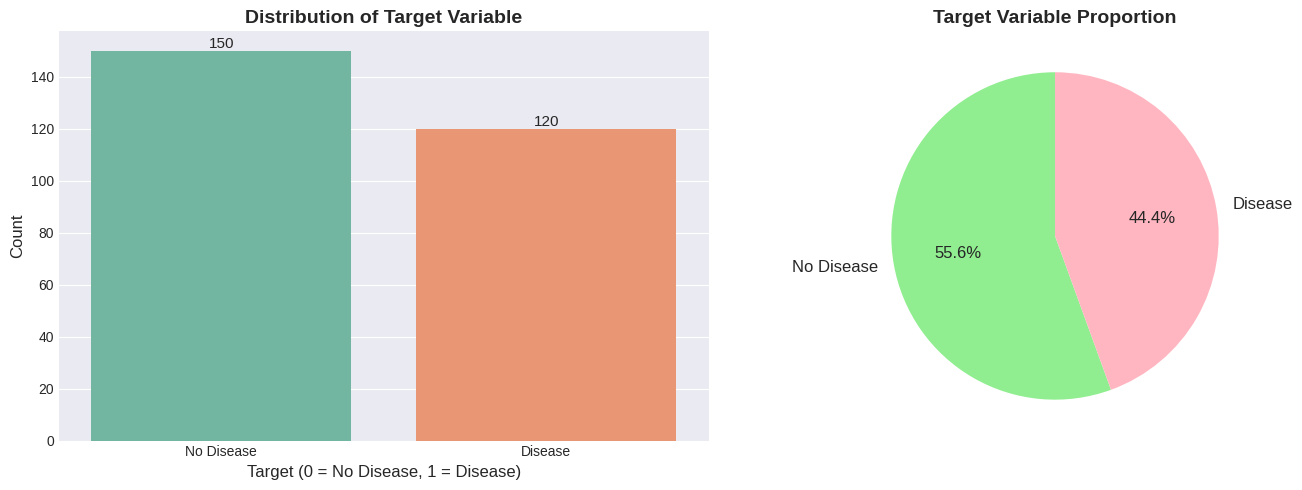

In [10]:
# Analyze the distribution of the target variable (class balance)

print("=" * 80)
print("TARGET VARIABLE ANALYSIS")
print("=" * 80)

# Class distribution
target_counts = df['target'].value_counts()
target_percent = (target_counts / len(df)) * 100

print("\n🎯 Target Variable Distribution:")
print(f"No Disease (0): {target_counts[0]} ({target_percent[0]:.2f}%)")
print(f"Disease (1):    {target_counts[1]} ({target_percent[1]:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

if abs(imbalance_ratio - 1) < 0.2:
    print("✅ Dataset is well-balanced!")
elif abs(imbalance_ratio - 1) < 0.5:
    print("⚠️ Minor imbalance detected.  Consider using stratified sampling.")
else:
    print("⚠️ Significant imbalance!  Consider using SMOTE or class weights.")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(x='target', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribution of Target Variable', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (0 = No Disease, 1 = Disease)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Disease', 'Disease'])

# Add counts on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=11)

# Pie chart
colors = ['#90EE90', '#FFB6C1']
axes[1].pie(target_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Target Variable Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 8. Univariate Analysis - Numerical Features

UNIVARIATE ANALYSIS - NUMERICAL FEATURES


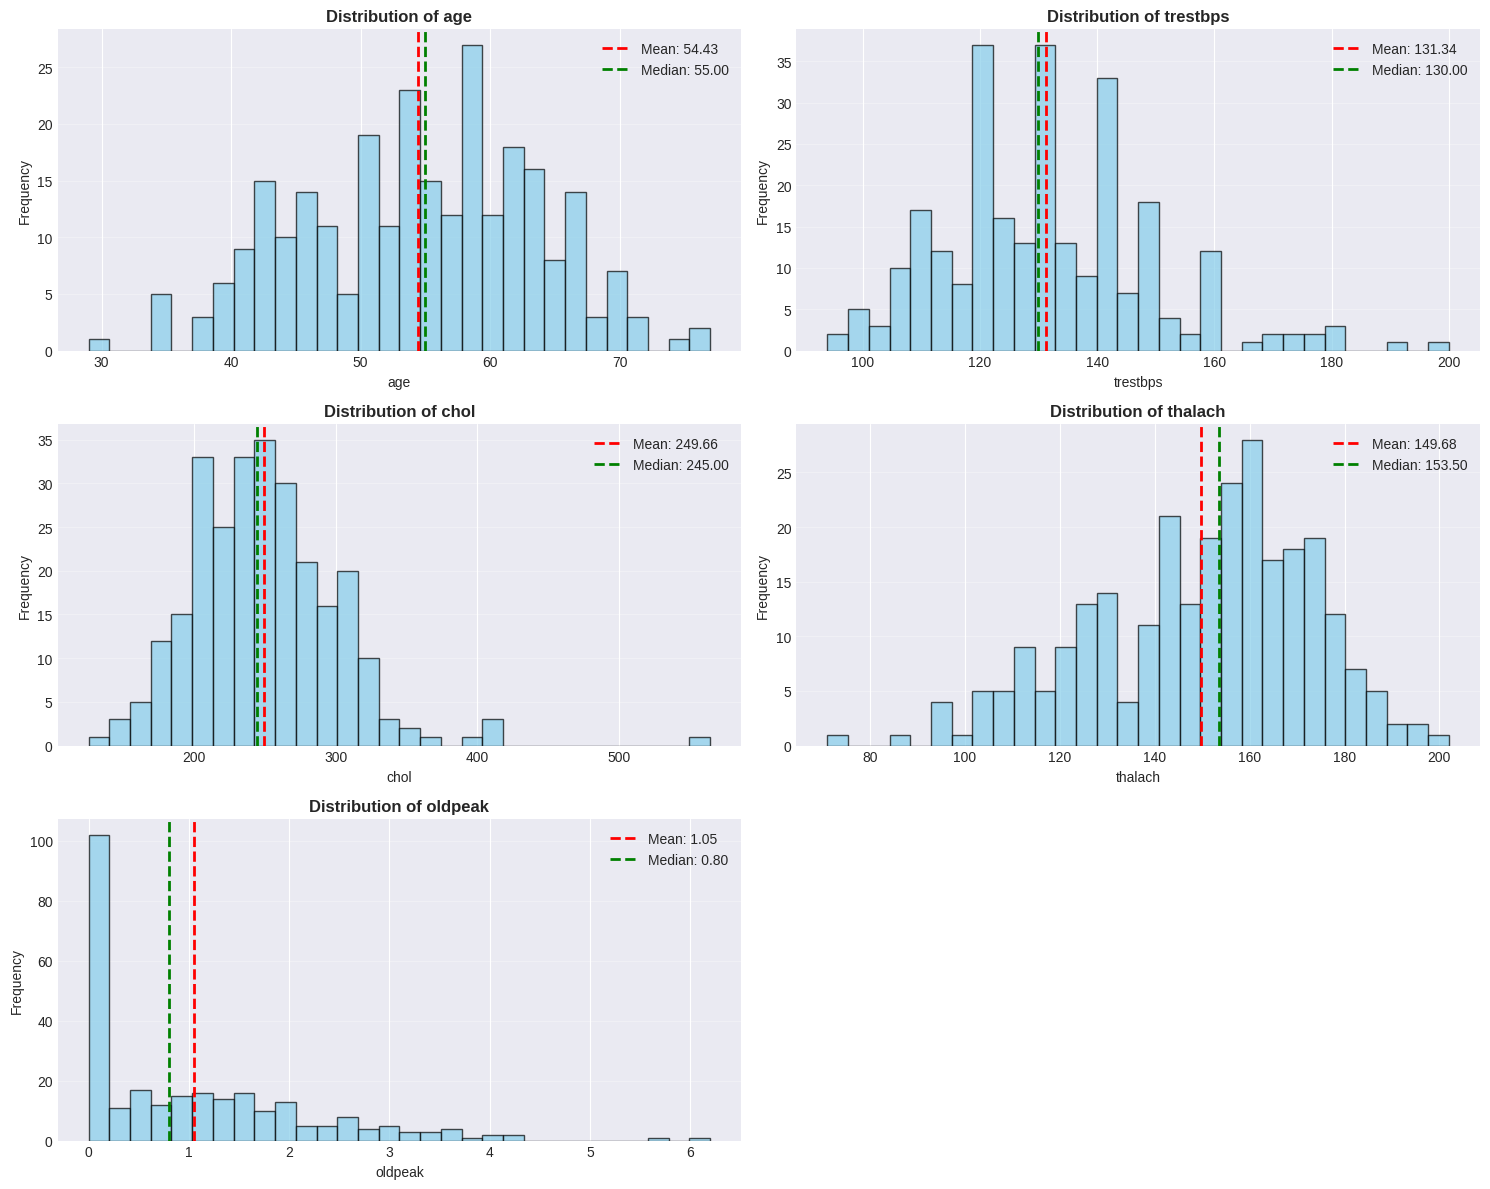


📊 Skewness Analysis:
age         : -0.164 (Fairly Symmetric)
trestbps    :  0.723 (Moderately Skewed)
chol        :  1.184 (Highly Skewed)
thalach     : -0.528 (Moderately Skewed)
oldpeak     :  1.263 (Highly Skewed)


In [11]:
# Distribution analysis of numerical features

print("=" * 80)
print("UNIVARIATE ANALYSIS - NUMERICAL FEATURES")
print("=" * 80)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# numerical_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    # Histogram with KDE
    axes[idx].hist(df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].axvline(df[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[feature].mean():.2f}')
    axes[idx].axvline(df[feature].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[feature].median():.2f}')
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()


# Statistical tests for normality
print("\n📊 Skewness Analysis:")
for feature in numerical_features:
    skewness = df[feature].skew()
    print(f"{feature:12s}: {skewness:6.3f} ", end='')
    if abs(skewness) < 0.5:
        print("(Fairly Symmetric)")
    elif abs(skewness) < 1:
        print("(Moderately Skewed)")
    else:
        print("(Highly Skewed)")

# 9. Univariate Analysis - Categorical Features

UNIVARIATE ANALYSIS - CATEGORICAL FEATURES


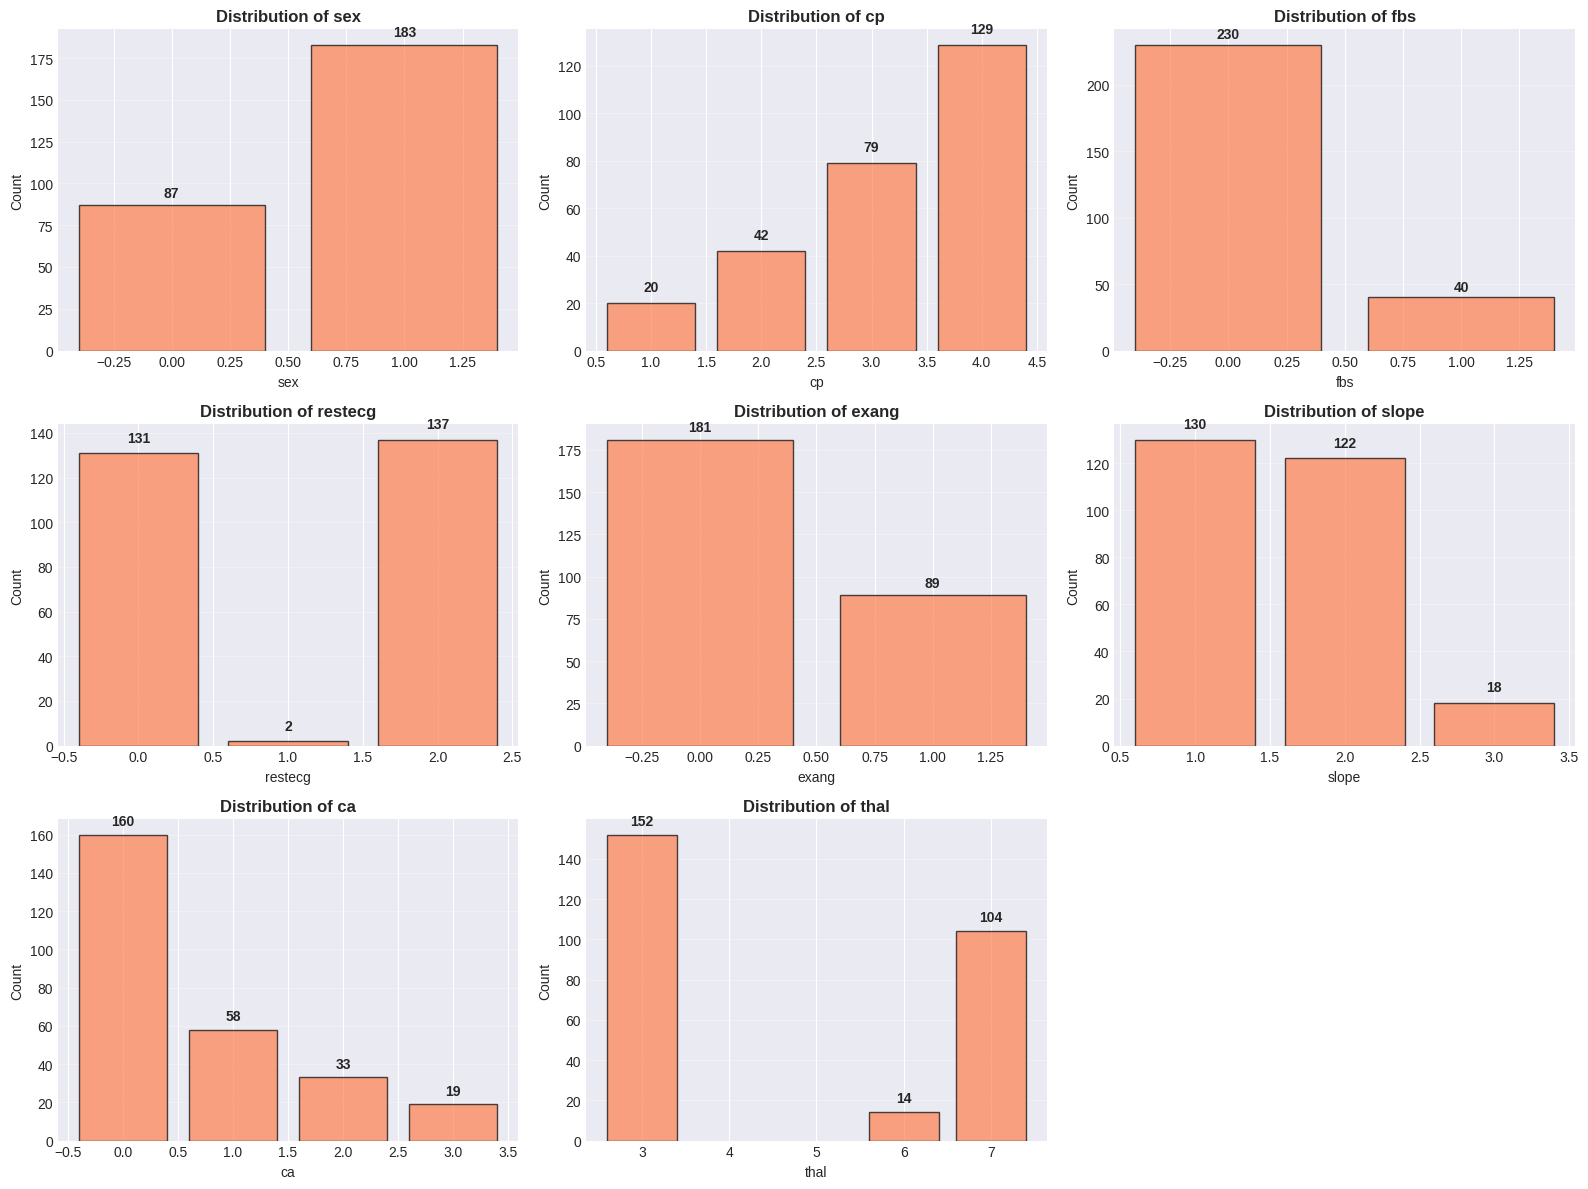

In [12]:
# Distribution analysis of categorical features

print("=" * 80)
print("UNIVARIATE ANALYSIS - CATEGORICAL FEATURES")
print("=" * 80)

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
# categorical_features = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if feature in df.columns:
        value_counts = df[feature].value_counts().sort_index()
        axes[idx].bar(value_counts.index, value_counts.values, color='coral', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('Count', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(value_counts.values):
            axes[idx].text(value_counts.index[i], v + 5, str(v), ha='center', fontweight='bold')

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# 10. Bivariate Analysis - Numerical vs Target

BIVARIATE ANALYSIS - NUMERICAL FEATURES vs TARGET


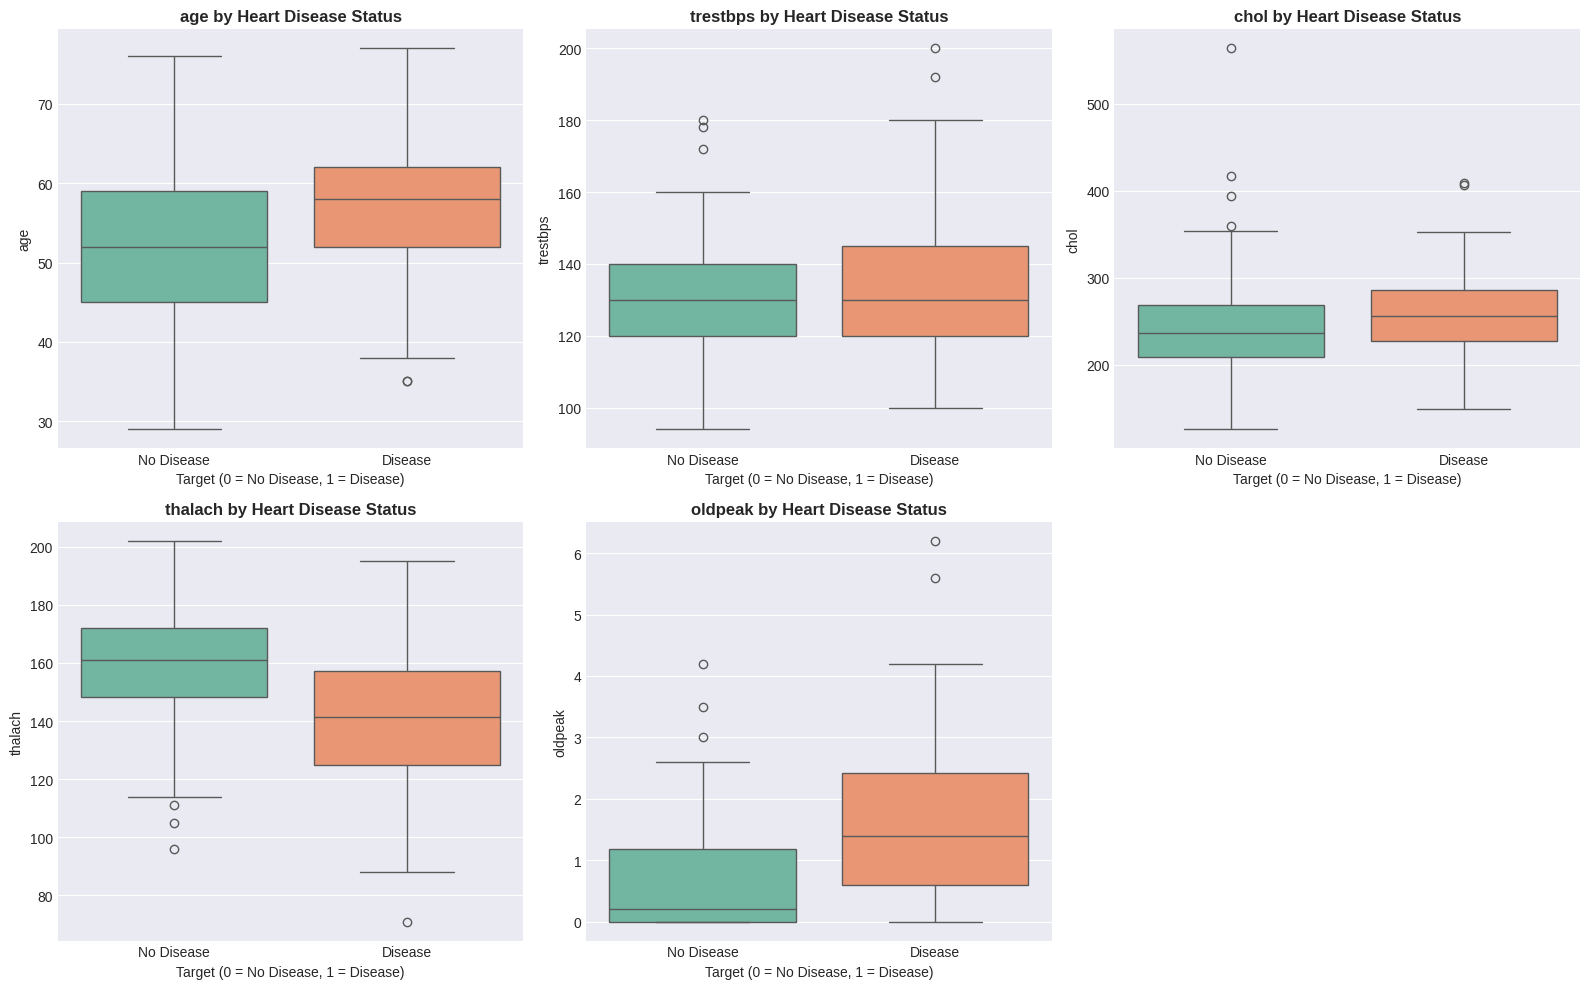

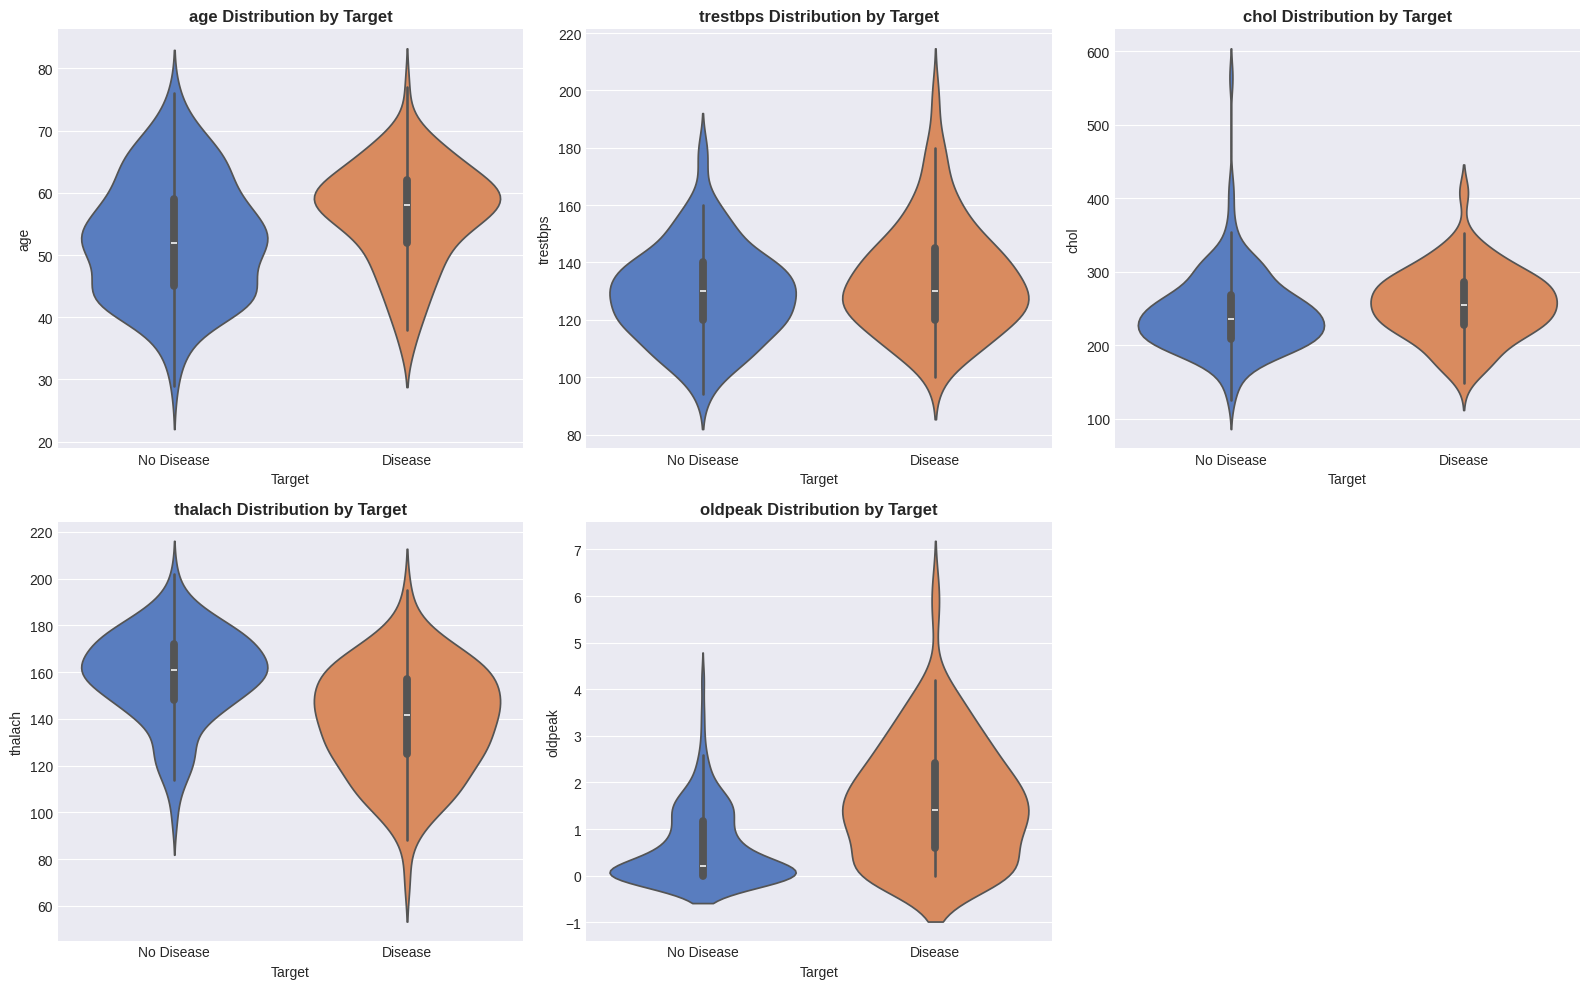


📊 Mean Values by Target:
          age  trestbps    chol  thalach  oldpeak
target                                           
0       52.71    128.87  244.21   158.33     0.62
1       56.59    134.44  256.47   138.86     1.58

📊 Median Values by Target:
         age  trestbps   chol  thalach  oldpeak
target                                         
0       52.0     130.0  236.0    161.0      0.2
1       58.0     130.0  255.5    141.5      1.4


In [13]:
# Analyze relationship between numerical features and target variable

print("=" * 80)
print("BIVARIATE ANALYSIS - NUMERICAL FEATURES vs TARGET")
print("=" * 80)

# numerical_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create binary target if needed (convert 'Heart Disease' to 0/1)
if 'target' not in df.columns:
    df['target'] = (df['Heart Disease'] == 'Presence').astype(int)

# Box plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.boxplot(x='target', y=feature, data=df, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{feature} by Heart Disease Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target (0 = No Disease, 1 = Disease)', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Violin plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.violinplot(x='target', y=feature, data=df, ax=axes[idx], palette='muted')
    axes[idx].set_title(f'{feature} Distribution by Target', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\n📊 Mean Values by Target:")
print(df.groupby('target')[numerical_features].mean().round(2))

print("\n📊 Median Values by Target:")
print(df.groupby('target')[numerical_features].median().round(2))

# 11. Bivariate Analysis - Categorical vs Target

BIVARIATE ANALYSIS - CATEGORICAL FEATURES vs TARGET


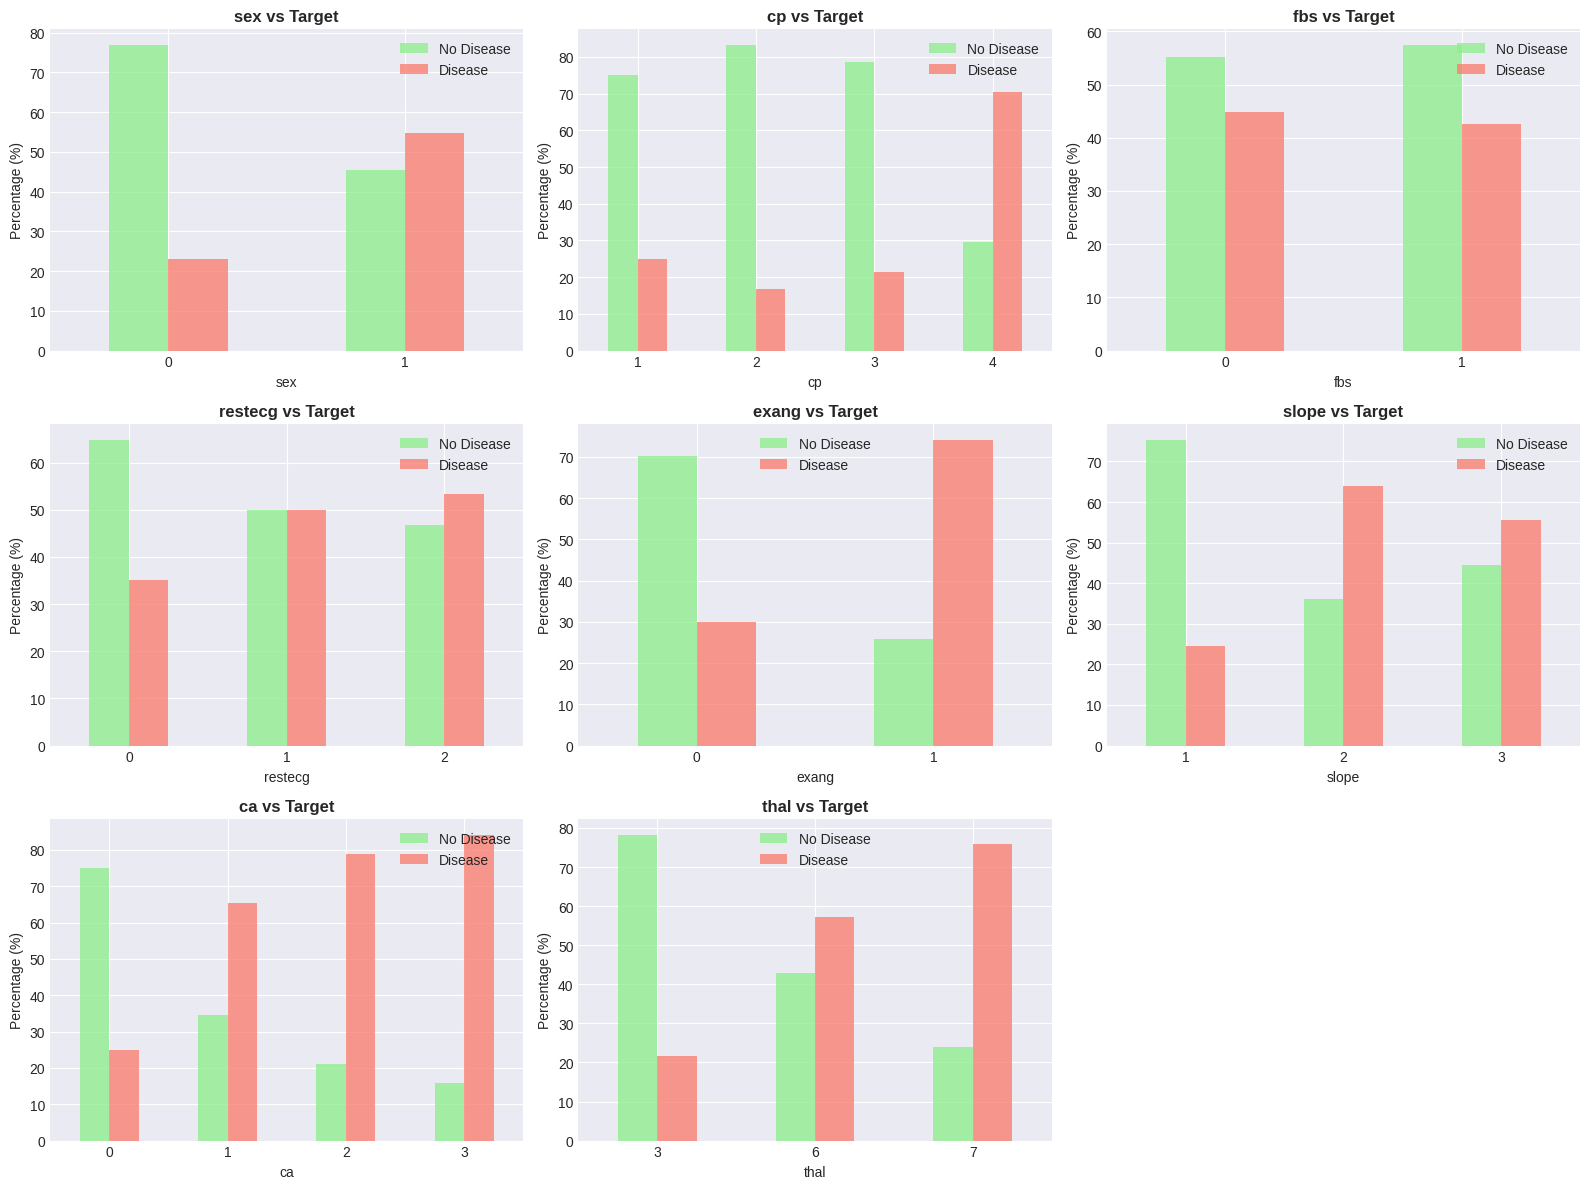


📊 Crosstab Analysis:

sex:
target    0    1  All
sex                  
0        67   20   87
1        83  100  183
All     150  120  270

cp:
target    0    1  All
cp                   
1        15    5   20
2        35    7   42
3        62   17   79
4        38   91  129
All     150  120  270

fbs:
target    0    1  All
fbs                  
0       127  103  230
1        23   17   40
All     150  120  270

restecg:
target     0    1  All
restecg               
0         85   46  131
1          1    1    2
2         64   73  137
All      150  120  270

exang:
target    0    1  All
exang                
0       127   54  181
1        23   66   89
All     150  120  270

slope:
target    0    1  All
slope                
1        98   32  130
2        44   78  122
3         8   10   18
All     150  120  270

ca:
target    0    1  All
ca                   
0       120   40  160
1        20   38   58
2         7   26   33
3         3   16   19
All     150  120  270

thal:
target    0    

In [14]:
# Analyze relationship between categorical features and target variable

print("=" * 80)
print("BIVARIATE ANALYSIS - CATEGORICAL FEATURES vs TARGET")
print("=" * 80)

# categorical_features = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if feature in df.columns:
        ct = pd.crosstab(df[feature], df['target'], normalize='index') * 100
        ct.plot(kind='bar', ax=axes[idx], color=['lightgreen', 'salmon'], alpha=0.8)
        axes[idx].set_title(f'{feature} vs Target', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('Percentage (%)', fontsize=10)
        axes[idx].legend(['No Disease', 'Disease'], loc='best')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Crosstab with counts
print("\n📊 Crosstab Analysis:")
for feature in categorical_features:
    if feature in df.columns:
        print(f"\n{feature}:")
        print(pd.crosstab(df[feature], df['target'], margins=True))

In [ ]:
# ============================================================================
# CELL 1: Import Libraries
# ============================================================================
"""
Heart Disease Prediction - Comprehensive Analysis
Author: [Your Name]
Date:  2026-01-04

This notebook performs end-to-end machine learning pipeline for predicting
heart disease based on medical indicators.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn. neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

import xgboost as xgb
import joblib

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

# ============================================================================
# CELL 2: Load Dataset
# ============================================================================
"""
Load the Heart Disease dataset from Kaggle
Dataset: https://www.kaggle.com/datasets/rishidamarla/heart-disease-prediction
"""

# Load from local file
df = pd.read_csv('data/heart_disease.csv')

print("✅ Dataset loaded successfully!")
print(f"\nDataset shape: {df. shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# ============================================================================
# CELL 2.5:  Rename Columns to Standard Names
# ============================================================================
"""
Rename columns to standard short names for easier coding
"""

# Mapping from current names to standard names
column_mapping = {
    'Age': 'age',
    'Sex': 'sex',
    'Chest pain type': 'cp',
    'BP': 'trestbps',
    'Cholesterol': 'chol',
    'FBS over 120': 'fbs',
    'EKG results': 'restecg',
    'Max HR': 'thalach',
    'Exercise angina': 'exang',
    'ST depression': 'oldpeak',
    'Slope of ST': 'slope',
    'Number of vessels fluro': 'ca',
    'Thallium':  'thal',
    'Heart Disease': 'target'
}

# Rename columns
df = df.rename(columns=column_mapping)

# Convert target to binary (0 = Absence, 1 = Presence)
df['target'] = (df['target'] == 'Presence').astype(int)

print("✅ Columns renamed successfully!")
print(f"\nNew column names: {list(df.columns)}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"\n0 = No Disease, 1 = Disease")

# Show first few rows with new names
display(df.head())

# ============================================================================
# CELL 3: Initial Data Exploration
# ============================================================================
"""
Quick overview of the dataset structure
"""

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

# First rows
print("\n📊 First 5 rows:")
display(df.head())

print("\n📊 Last 5 rows:")
display(df.tail())

# Data types and non-null counts
print("\n📋 Dataset Info:")
df.info()

# ============================================================================
# CELL 4: Feature Description
# ============================================================================
"""
Understanding each feature in the dataset
"""

feature_descriptions = {
    'age': 'Age in years',
    'sex': 'Sex (1 = male; 0 = female)',
    'cp': 'Chest pain type (0-3)',
    'trestbps': 'Resting blood pressure (mm Hg)',
    'chol': 'Serum cholesterol (mg/dl)',
    'fbs': 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
    'restecg': 'Resting electrocardiographic results (0-2)',
    'thalach': 'Maximum heart rate achieved',
    'exang': 'Exercise induced angina (1 = yes; 0 = no)',
    'oldpeak': 'ST depression induced by exercise relative to rest',
    'slope': 'Slope of peak exercise ST segment (0-2)',
    'ca': 'Number of major vessels colored by fluoroscopy (0-3)',
    'thal': 'Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)',
    'target': 'Heart disease diagnosis (1 = disease; 0 = no disease)'
}

print("=" * 80)
print("FEATURE DESCRIPTIONS")
print("=" * 80)
for feature, description in feature_descriptions.items():
    print(f"• {feature: 12s}: {description}")

# ============================================================================
# CELL 5: Statistical Summary
# ============================================================================
"""
Statistical summary of numerical features
"""

print("=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

# Descriptive statistics
print("\n📈 Numerical Features Statistics:")
display(df.describe().T)

print("\n📊 Categorical Features Value Counts:")
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().sort_index())

# ============================================================================
# CELL 6: Missing Values Analysis
# ============================================================================
"""
Check for missing values and data quality issues
"""

print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

# Missing values count
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percent': missing_percent
})

print("\n🔍 Missing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("\n✅ No missing values found!  Data quality is excellent.")
else:
    print(f"\n⚠️ Total missing values: {missing_df['Missing_Count'].sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔍 Duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows.  Consider removing them.")
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed.  New shape: {df.shape}")

# ============================================================================
# CELL 7: Target Variable Analysis
# ============================================================================
"""
Analyze the distribution of the target variable (class balance)
"""

print("=" * 80)
print("TARGET VARIABLE ANALYSIS")
print("=" * 80)

# Class distribution
target_counts = df['target'].value_counts()
target_percent = (target_counts / len(df)) * 100

print("\n🎯 Target Variable Distribution:")
print(f"No Disease (0): {target_counts[0]} ({target_percent[0]:.2f}%)")
print(f"Disease (1):    {target_counts[1]} ({target_percent[1]:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

if abs(imbalance_ratio - 1) < 0.2:
    print("✅ Dataset is well-balanced!")
elif abs(imbalance_ratio - 1) < 0.5:
    print("⚠️ Minor imbalance detected.  Consider using stratified sampling.")
else:
    print("⚠️ Significant imbalance!  Consider using SMOTE or class weights.")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(x='target', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribution of Target Variable', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (0 = No Disease, 1 = Disease)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Disease', 'Disease'])

# Add counts on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=11)

# Pie chart
colors = ['#90EE90', '#FFB6C1']
axes[1].pie(target_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Target Variable Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# CELL 8: Univariate Analysis - Numerical Features
# ============================================================================
"""
Distribution analysis of numerical features
"""

print("=" * 80)
print("UNIVARIATE ANALYSIS - NUMERICAL FEATURES")
print("=" * 80)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    # Histogram with KDE
    axes[idx].hist(df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].axvline(df[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[feature].mean():.2f}')
    axes[idx].axvline(df[feature].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[feature].median():.2f}')
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Statistical tests for normality
print("\n📊 Skewness Analysis:")
for feature in numerical_features:
    skewness = df[feature].skew()
    print(f"{feature: 12s}: {skewness: 6.3f} ", end='')
    if abs(skewness) < 0.5:
        print("(Fairly Symmetric)")
    elif abs(skewness) < 1:
        print("(Moderately Skewed)")
    else:
        print("(Highly Skewed)")

# ============================================================================
# CELL 9: Univariate Analysis - Categorical Features
# ============================================================================
"""
Distribution analysis of categorical features
"""

print("=" * 80)
print("UNIVARIATE ANALYSIS - CATEGORICAL FEATURES")
print("=" * 80)

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if feature in df.columns:
        value_counts = df[feature].value_counts().sort_index()
        axes[idx].bar(value_counts. index, value_counts.values, color='coral', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('Count', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(value_counts.values):
            axes[idx].text(value_counts.index[i], v + 5, str(v), ha='center', fontweight='bold')

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# ============================================================================
# CELL 10: Bivariate Analysis - Numerical vs Target
# ============================================================================
"""
Analyze relationship between numerical features and target variable
"""

print("=" * 80)
print("BIVARIATE ANALYSIS - NUMERICAL FEATURES vs TARGET")
print("=" * 80)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Box plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.boxplot(x='target', y=feature, data=df, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{feature} by Heart Disease Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target (0 = No Disease, 1 = Disease)', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Violin plots
fig, axes = plt. subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.violinplot(x='target', y=feature, data=df, ax=axes[idx], palette='muted')
    axes[idx].set_title(f'{feature} Distribution by Target', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\n📊 Mean Values by Target:")
print(df.groupby('target')[numerical_features].mean().round(2))

print("\n📊 Median Values by Target:")
print(df.groupby('target')[numerical_features].median().round(2))

# ============================================================================
# CELL 11: Bivariate Analysis - Categorical vs Target
# ============================================================================
"""
Analyze relationship between categorical features and target variable
"""

print("=" * 80)
print("BIVARIATE ANALYSIS - CATEGORICAL FEATURES vs TARGET")
print("=" * 80)

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if feature in df.columns:
        ct = pd.crosstab(df[feature], df['target'], normalize='index') * 100
        ct. plot(kind='bar', ax=axes[idx], color=['lightgreen', 'salmon'], alpha=0.8)
        axes[idx].set_title(f'{feature} vs Target', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('Percentage (%)', fontsize=10)
        axes[idx].legend(['No Disease', 'Disease'], loc='best')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Crosstab with counts
print("\n📊 Crosstab Analysis:")
for feature in categorical_features:
    if feature in df.columns:
        print(f"\n{feature}:")
        print(pd.crosstab(df[feature], df['target'], margins=True))

# ============================================================================
# CELL 12: Correlation Analysis
# ============================================================================
"""
Analyze correlations between features
"""

print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Correlation matrix
correlation_matrix = numeric_df.corr()

print("\n📊 Correlation with Target:")
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print(target_corr)

# Heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np. ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Heart Disease Dataset', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top correlations with target
print("\n📊 Top Positive Correlations with Target:")
positive_corr = target_corr[target_corr > 0.1]. drop('target')
if len(positive_corr) > 0:
    print(positive_corr)
else:
    print("None found")

print("\n📊 Top Negative Correlations with Target:")
negative_corr = target_corr[target_corr < -0.1]
if len(negative_corr) > 0:
    print(negative_corr)
else:
    print("None found")

# Correlation between features (excluding target)
print("\n⚠️ High Feature Correlations (Multicollinearity Check):")
feature_corr = correlation_matrix.drop('target', axis=0).drop('target', axis=1)
high_corr_pairs = []

for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.7:
            high_corr_pairs.append((feature_corr.columns[i], feature_corr.columns[j], feature_corr.iloc[i, j]))

if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} <-> {feat2}: {corr:.3f}")
else:
    print("✅ No high multicollinearity detected!")

# ============================================================================
# CELL 13: Pairplot for Key Features
# ============================================================================
"""
Visualize relationships between key features
"""

print("=" * 80)
print("PAIRPLOT - KEY FEATURES")
print("=" * 80)

# Select key features based on correlation with target
key_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']

# Verify all features exist
available_features = [f for f in key_features if f in df.columns]
print(f"Creating pairplot for:  {', '.join(available_features)}")
print("This may take a moment...")

pairplot = sns.pairplot(df[available_features], hue='target', palette='Set1',
                        diag_kind='kde', plot_kws={'alpha':  0.6},
                        height=2.5)
pairplot.fig.suptitle('Pairplot of Key Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()

print("✅ Pairplot complete!")

# ============================================================================
# CELL 14: Outlier Detection
# ============================================================================
"""
Detect and visualize outliers using IQR method
"""

print("=" * 80)
print("OUTLIER DETECTION")
print("=" * 80)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("\n📊 Outlier Summary (IQR Method):")
print(f"{'Feature':<12} {'Outliers':<10} {'Percentage':<12} {'Lower Bound':<15} {'Upper Bound':<15}")
print("-" * 70)

outlier_summary = {}
for feature in numerical_features:
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100
    outlier_summary[feature] = outlier_count
    print(f"{feature:<12} {outlier_count:<10} {outlier_pct: <12.2f}% {lower:<15.2f} {upper:<15.2f}")

# Boxplot for outlier visualization
fig, axes = plt.subplots(1, len(numerical_features), figsize=(18, 5))

for idx, feature in enumerate(numerical_features):
    sns.boxplot(y=df[feature], ax=axes[idx], color='lightblue')
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value', fontsize=10)

    # Add count of outliers
    outlier_count = outlier_summary[feature]
    axes[idx].text(0, df[feature].max(), f'Outliers: {outlier_count}',
                   ha='center', va='bottom', fontweight='bold', color='red')

plt.suptitle('Outlier Detection - Box Plots', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Note:  Outliers are not necessarily errors.  In medical data, extreme values may be important!")
print("Consider keeping outliers unless they are data entry errors.")

# ============================================================================
# CELL 15: Data Preprocessing - Train/Test Split
# ============================================================================
"""
Split data into training and testing sets
"""

print("=" * 80)
print("DATA PREPROCESSING - TRAIN/TEST SPLIT")
print("=" * 80)

# Separate features and target
X = df. drop('target', axis=1)
y = df['target']

print(f"\n📊 Original Dataset:")
print(f"Total samples: {len(df)}")
print(f"Features: {X.shape[1]}")
print(f"Target distribution:\n{y.value_counts()}")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n📊 After Split:")
print(f"Training set:  {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Testing set:   {X_test.shape[0]} samples ({X_test. shape[0]/len(df)*100:.1f}%)")

print(f"\n📊 Training Set Target Distribution:")
print(y_train.value_counts())
print(f"Class proportion: {y_train.value_counts(normalize=True).round(3).to_dict()}")

print(f"\n📊 Testing Set Target Distribution:")
print(y_test.value_counts())
print(f"Class proportion: {y_test.value_counts(normalize=True).round(3).to_dict()}")

print("\n✅ Stratified split ensures balanced class distribution in both sets!")

# ============================================================================
# CELL 16: Feature Scaling
# ============================================================================
"""
Standardize features using StandardScaler
"""

print("=" * 80)
print("FEATURE SCALING")
print("=" * 80)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X. columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("✅ Features scaled using StandardScaler")
print("\n📊 Scaling Statistics (from training data):")
print(f"{'Feature':<12} {'Original Mean':<15} {'Original Std':<15} {'Scaled Mean':<15} {'Scaled Std':<15}")
print("-" * 75)

for col in X. columns:
    orig_mean = X_train[col].mean()
    orig_std = X_train[col]. std()
    scaled_mean = X_train_scaled[col]. mean()
    scaled_std = X_train_scaled[col]. std()
    print(f"{col:<12} {orig_mean:<15.2f} {orig_std:<15.2f} {scaled_mean: <15.6f} {scaled_std:<15.6f}")

# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].boxplot([X_train[col] for col in X.columns], labels=X.columns)
axes[0].set_title('Before Scaling', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# After scaling
axes[1].boxplot([X_train_scaled[col] for col in X.columns], labels=X.columns)
axes[1].set_title('After Scaling (Standardized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Standardized Value', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# CELL 17: Baseline Model - Dummy Classifier
# ============================================================================
"""
Establish baseline performance using a dummy classifier
"""

print("=" * 80)
print("BASELINE MODEL - DUMMY CLASSIFIER")
print("=" * 80)

from sklearn.dummy import DummyClassifier

# Most frequent strategy
dummy_most_frequent = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_most_frequent.fit(X_train_scaled, y_train)
dummy_pred_mf = dummy_most_frequent. predict(X_test_scaled)

# Stratified strategy
dummy_stratified = DummyClassifier(strategy='stratified', random_state=42)
dummy_stratified.fit(X_train_scaled, y_train)
dummy_pred_strat = dummy_stratified.predict(X_test_scaled)

print("\n📊 Baseline Performance:")
print(f"\nMost Frequent Strategy:")
print(f"  Accuracy: {accuracy_score(y_test, dummy_pred_mf):.4f}")

print(f"\nStratified Strategy:")
print(f"  Accuracy: {accuracy_score(y_test, dummy_pred_strat):.4f}")

baseline_accuracy = accuracy_score(y_test, dummy_pred_mf)
print(f"\n💡 Any model scoring below {baseline_accuracy:.4f} is worse than random guessing!")
print("✅ This is our minimum acceptable performance threshold.")

# ============================================================================
# CELL 18: Model Training - Multiple Algorithms
# ============================================================================
"""
Train multiple classification models and compare performance
"""

print("=" * 80)
print("MODEL TRAINING - MULTIPLE ALGORITHMS")
print("=" * 80)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Store results
results = {}

print("\n🚀 Training models.. .\n")

for name, model in models.items():
    print(f"Training {name}.. .", end=' ')

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model. predict(X_test_scaled)
    y_pred_proba = model. predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    print(f"✅ Accuracy: {accuracy:.4f}")

print("\n✅ All models trained successfully!")

# ============================================================================
# CELL 19: Model Comparison - Performance Metrics
# ============================================================================
"""
Compare performance of all trained models
"""

print("=" * 80)
print("MODEL COMPARISON - PERFORMANCE METRICS")
print("=" * 80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results. keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("\n📊 Model Performance Comparison:")
display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics_list):
    ax = axes[idx // 2, idx % 2]

    data = comparison_df. sort_values(metric, ascending=True)
    colors = plt.cm.RdYlGn(data[metric] / data[metric].max())

    ax.barh(data['Model'], data[metric], color=colors)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'Model Comparison - {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1])

    # Add value labels
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:. 4f}")
print(f"   Improvement over baseline: {(best_accuracy - baseline_accuracy):.4f} ({(best_accuracy - baseline_accuracy)/baseline_accuracy*100:.1f}%)")

# ============================================================================
# CELL 20: Cross-Validation Analysis
# ============================================================================
"""
Perform k-fold cross-validation to assess model stability
"""

print("=" * 80)
print("CROSS-VALIDATION ANALYSIS")
print("=" * 80)

cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"\n🔄 Performing {cv_folds}-Fold Cross-Validation.. .\n")

cv_results = {}

for name, model in models.items():
    print(f"Evaluating {name}...", end=' ')

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

    cv_results[name] = {
        'scores': cv_scores,
        'mean':  cv_scores.mean(),
        'std': cv_scores.std()
    }

    print(f"✅ Mean CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Create CV comparison DataFrame
cv_comparison_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV Mean':  [cv_results[m]['mean'] for m in cv_results. keys()],
    'CV Std': [cv_results[m]['std'] for m in cv_results.keys()],
    'Test Accuracy': [results[m]['accuracy'] for m in cv_results.keys()]
}).sort_values('CV Mean', ascending=False)

print("\n📊 Cross-Validation Results:")
display(cv_comparison_df)

# Visualize CV results
plt.figure(figsize=(14, 8))

models_sorted = cv_comparison_df['Model'].values
cv_means = cv_comparison_df['CV Mean'].values
cv_stds = cv_comparison_df['CV Std'].values

y_pos = np.arange(len(models_sorted))

plt.barh(y_pos, cv_means, xerr=cv_stds, alpha=0.7, color='skyblue',
         edgecolor='black', error_kw={'elinewidth': 2, 'ecolor': 'red'})
plt.yticks(y_pos, models_sorted)
plt.xlabel('Cross-Validation Accuracy', fontsize=12)
plt.title(f'{cv_folds}-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
plt.axvline(x=baseline_accuracy, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
print("\n⚠️ Overfitting Check (CV Score vs Test Score):")
for name in cv_results.keys():
    cv_score = cv_results[name]['mean']
    test_score = results[name]['accuracy']
    diff = cv_score - test_score

    print(f"{name: 25s}: CV={cv_score:.4f}, Test={test_score:. 4f}, Diff={diff: +.4f}", end='')

    if abs(diff) > 0.05:
        print(" ⚠️ Potential overfitting/underfitting")
    else:
        print(" ✅ Good generalization")

# ============================================================================
# CELL 21: Confusion Matrices for All Models
# ============================================================================
"""
Visualize confusion matrices for all models
"""

print("=" * 80)
print("CONFUSION MATRICES")
print("=" * 80)

fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=False, square=True, linewidths=2, linecolor='black')
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:. 4f}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])
    axes[idx].set_yticklabels(['No Disease', 'Disease'])

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrices
print("\n📊 Detailed Confusion Matrix Metrics:")
print(f"{'Model':<25} {'TN':<6} {'FP':<6} {'FN':<6} {'TP':<6} {'Specificity':<12} {'Sensitivity':<12}")
print("-" * 85)

for name, result in results.items():
    cm = confusion_matrix(y_test, result['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"{name: <25} {tn:<6} {fp:<6} {fn: <6} {tp:<6} {specificity:<12.4f} {sensitivity:<12.4f}")

# ============================================================================
# CELL 22: ROC Curves
# ============================================================================
"""
Plot ROC curves for models with probability predictions
"""

print("=" * 80)
print("ROC CURVES ANALYSIS")
print("=" * 80)

plt.figure(figsize=(12, 8))

# Plot ROC curve for each model
for name, result in results.items():
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc = result['roc_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:. 3f})', linewidth=2)

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find best model by ROC-AUC
roc_auc_scores = {name: result['roc_auc'] for name, result in results.items() if not np.isnan(result['roc_auc'])}
best_roc_model = max(roc_auc_scores, key=roc_auc_scores.get)

print(f"\n🏆 Best Model by ROC-AUC:  {best_roc_model} (AUC = {roc_auc_scores[best_roc_model]:.4f})")

# ============================================================================
# CELL 23: Precision-Recall Curves
# ============================================================================
"""
Plot Precision-Recall curves (important for imbalanced datasets)
"""

print("=" * 80)
print("PRECISION-RECALL CURVES")
print("=" * 80)

plt.figure(figsize=(12, 8))

# Plot PR curve for each model
for name, result in results.items():
    if result['y_pred_proba'] is not None:
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        avg_precision = average_precision_score(y_test, result['y_pred_proba'])
        plt.plot(recall_curve, precision_curve,
                label=f'{name} (AP = {avg_precision:. 3f})', linewidth=2)

# Plot baseline (proportion of positive class)
baseline_precision = y_test.sum() / len(y_test)
plt.axhline(y=baseline_precision, color='k', linestyle='--',
           label=f'Baseline (AP = {baseline_precision:. 3f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 24: Feature Importance - Random Forest
# ============================================================================
"""
Analyze feature importance from Random Forest model
"""

print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST")
print("=" * 80)

# Get Random Forest model
rf_model = results['Random Forest']['model']

# Extract feature importances
feature_importance = pd. DataFrame({
    'Feature': X. columns,
    'Importance':  rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance (Random Forest):")
display(feature_importance)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].barh(feature_importance['Feature'], feature_importance['Importance'],
            color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add percentage labels
for i, v in enumerate(feature_importance['Importance']):
    axes[0].text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')

# Pie chart for top features
top_n = 5
top_features = feature_importance.head(top_n)
other_importance = feature_importance.iloc[top_n: ]['Importance']. sum()

pie_data = list(top_features['Importance']) + [other_importance]
pie_labels = list(top_features['Feature']) + ['Others']

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90,
           colors=sns.color_palette('Set3', len(pie_labels)))
axes[1].set_title(f'Top {top_n} Features Contribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Top 3 Most Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")

# ============================================================================
# CELL 25: Feature Importance - XGBoost
# ============================================================================
"""
Analyze feature importance from XGBoost model
"""

print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS - XGBOOST")
print("=" * 80)

# Get XGBoost model
xgb_model = results['XGBoost']['model']

# Extract feature importances
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance (XGBoost):")
display(xgb_importance)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'],
        color='darkgreen', alpha=0.7, edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(xgb_importance['Importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Compare RF and XGBoost importance
comparison_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf_model.feature_importances_,
    'XGB_Importance': xgb_model.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("\n📊 Comparison:  Random Forest vs XGBoost Feature Importance:")
display(comparison_importance)

# Correlation between importances
importance_corr = comparison_importance[['RF_Importance', 'XGB_Importance']].corr().iloc[0, 1]
print(f"\n📊 Correlation between RF and XGBoost importance: {importance_corr:.4f}")

# ============================================================================
# CELL 26: Hyperparameter Tuning - Random Forest
# ============================================================================
"""
Optimize Random Forest hyperparameters using GridSearchCV
"""

print("=" * 80)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("=" * 80)

# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print(f"\n🔍 Parameter Grid:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid_rf.values()])}")

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\n🚀 Starting Grid Search...  (this may take several minutes)")

# Fit grid search
grid_search_rf. fit(X_train_scaled, y_train)

print("\n✅ Grid Search Complete!")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best Cross-Validation Score: {grid_search_rf. best_score_:.4f}")

# Test on test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model. predict(X_test_scaled)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)

print(f"📊 Test Set Accuracy: {best_rf_accuracy:.4f}")
print(f"📊 Improvement over default RF: {best_rf_accuracy - results['Random Forest']['accuracy']:.4f}")

# Visualize grid search results
cv_results_df = pd.DataFrame(grid_search_rf.cv_results_)
top_results = cv_results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print("\n📊 Top 10 Parameter Combinations:")
display(top_results)

# ============================================================================
# CELL 27: Hyperparameter Tuning - XGBoost
# ============================================================================
"""
Optimize XGBoost hyperparameters using GridSearchCV
"""

print("=" * 80)
print("HYPERPARAMETER TUNING - XGBOOST")
print("=" * 80)

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

print(f"\n🔍 Parameter Grid:")
for param, values in param_grid_xgb.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid_xgb.values()])}")

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\n🚀 Starting Grid Search...  (this may take several minutes)")

# Fit grid search
grid_search_xgb.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Complete!")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_search_xgb.best_params_. items():
    print(f"  {param}: {value}")

print(f"\n📊 Best Cross-Validation Score: {grid_search_xgb. best_score_:.4f}")

# Test on test set
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)

print(f"📊 Test Set Accuracy: {best_xgb_accuracy:. 4f}")
print(f"📊 Improvement over default XGBoost: {best_xgb_accuracy - results['XGBoost']['accuracy']:.4f}")

# ============================================================================
# CELL 28: Final Model Selection
# ============================================================================
"""
Select the best model based on all evaluations
"""

print("=" * 80)
print("FINAL MODEL SELECTION")
print("=" * 80)

# Compare all models including tuned versions
final_comparison = pd.DataFrame({
    'Model': list(results.keys()) + ['RF (Tuned)', 'XGBoost (Tuned)'],
    'Test Accuracy': [results[m]['accuracy'] for m in results.keys()] +
                     [best_rf_accuracy, best_xgb_accuracy],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()] +
                [f1_score(y_test, y_pred_best_rf), f1_score(y_test, y_pred_best_xgb)],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()] +
               [roc_auc_score(y_test, best_rf_model. predict_proba(X_test_scaled)[:, 1]),
                roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1])]
}).sort_values('Test Accuracy', ascending=False)

print("\n📊 Final Model Comparison (Including Tuned Models):")
display(final_comparison)

# Select best model
best_final_model_name = final_comparison.iloc[0]['Model']
best_final_accuracy = final_comparison.iloc[0]['Test Accuracy']

print(f"\n🏆 FINAL BEST MODEL: {best_final_model_name}")
print(f"   Test Accuracy: {best_final_accuracy:.4f}")
print(f"   F1-Score: {final_comparison.iloc[0]['F1-Score']:.4f}")
print(f"   ROC-AUC: {final_comparison.iloc[0]['ROC-AUC']:.4f}")

# Determine which model object to use
if best_final_model_name == 'RF (Tuned)':
    final_best_model = best_rf_model
elif best_final_model_name == 'XGBoost (Tuned)':
    final_best_model = best_xgb_model
else:
    final_best_model = results[best_final_model_name]['model']

# ============================================================================
# CELL 29: Final Model Evaluation
# ============================================================================
"""
Comprehensive evaluation of the final best model
"""

print("=" * 80)
print(f"FINAL MODEL EVALUATION - {best_final_model_name}")
print("=" * 80)

# Make predictions
y_pred_final = final_best_model.predict(X_test_scaled)
y_pred_proba_final = final_best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate all metrics
final_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_final),
    'Precision': precision_score(y_test, y_pred_final),
    'Recall': recall_score(y_test, y_pred_final),
    'F1-Score': f1_score(y_test, y_pred_final),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_final),
    'Average Precision': average_precision_score(y_test, y_pred_proba_final)
}

print("\n📊 Final Model Metrics:")
for metric, value in final_metrics.items():
    print(f"  {metric: <20}:  {value:.4f}")

# Confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"  True Negatives:   {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives:  {fn}")
print(f"  True Positives:  {tp}")

print(f"\n📊 Additional Metrics:")
print(f"  Specificity: {tn/(tn+fp):.4f}")
print(f"  Sensitivity: {tp/(tp+fn):.4f}")
print(f"  NPV (Negative Predictive Value): {tn/(tn+fn):.4f}")
print(f"  PPV (Positive Predictive Value): {tp/(tp+fp):.4f}")

# Visualize final confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           square=True, linewidths=2, linecolor='black',
           xticklabels=['No Disease', 'Disease'],
           yticklabels=['No Disease', 'Disease'])
axes[0].set_title(f'Confusion Matrix - {best_final_model_name}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
           square=True, linewidths=2, linecolor='black',
           xticklabels=['No Disease', 'Disease'],
           yticklabels=['No Disease', 'Disease'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Disease', 'Disease']))

# ============================================================================
# CELL 30: Final Model ROC and PR Curves
# ============================================================================
"""
Visualize ROC and Precision-Recall curves for the final model
"""

print("=" * 80)
print(f"ROC & PR CURVES - {best_final_model_name}")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_final)
roc_auc = roc_auc_score(y_test, y_pred_proba_final)

axes[0].plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title(f'ROC Curve - {best_final_model_name}', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_final)
avg_precision = average_precision_score(y_test, y_pred_proba_final)

axes[1].plot(recall_curve, precision_curve, color='darkgreen', lw=3,
            label=f'PR curve (AP = {avg_precision:.3f})')
axes[1].axhline(y=y_test.sum()/len(y_test), color='navy', linestyle='--', lw=2,
               label=f'Baseline (AP = {y_test.sum()/len(y_test):.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()